In [39]:
#Packages 
import numpy as np
import xarray as xr
import glob
import cmocean.cm as cmo
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import warnings
warnings.filterwarnings("ignore") #turns off annoying warnings
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FuncFormatter
import mosaic
from matplotlib.colors import SymLogNorm
from matplotlib.colors import LinearSegmentedColormap

In [40]:
def interp_mphy(ds):
    # Step 1: Interpolate (average)
    mphys_interp = 0.5 * (
        ds.chiPhyVerSalt.isel(nVertLevelsP1=slice(0, -1)) +
        ds.chiPhyVerSalt.isel(nVertLevelsP1=slice(1, None))
    )
    # Step 2: Rename the dimension
    mphys_interp = mphys_interp.rename({'nVertLevelsP1': 'nVertLevels'})
    # Step 3: Assign new coordinates
    mphy_salt = mphys_interp.assign_coords(nVertLevels=ds.nVertLevels)
    ds['chiPhyVerSalt'] = mphy_salt

    # Step 1: Interpolate (average)
    mphyt_interp = 0.5 * (
        ds.chiPhyVerTemp.isel(nVertLevelsP1=slice(0, -1)) +
        ds.chiPhyVerTemp.isel(nVertLevelsP1=slice(1, None))
    )
    # Step 2: Rename the dimension
    mphyt_interp = mphyt_interp.rename({'nVertLevelsP1': 'nVertLevels'})
    # Step 3: Assign new coordinates
    mphy_temp = mphyt_interp.assign_coords(nVertLevels=ds.nVertLevels)
    ds['chiPhyVerTemp'] = mphy_temp

def center_vertices(dsg, hres):
    # Clean up the indexing so the domain is centered for plotting

    # Original vertices (x,y) arrays
    xv = dsg.xVertex.values
    yv = dsg.yVertex.values
    
    # Compute the new vertices based on your filtering and offset logic:
    
    # 1. Extract verticesOnCell (assuming shape: [nCells, maxVerticesPerCell])
    voc = dsg.verticesOnCell.values
    
    # 2. Build verts as in your snippet (shape: [nCells, maxVerticesPerCell, 2])
    verts = np.dstack((xv[voc - 1], yv[voc - 1]))
    nverts = np.sum(voc != 0, axis=1)
    verts_list = [vert[:n] for vert, n in zip(verts, nverts)]
    
    # 3. Filter verts using np.ptp
    idx = [np.ptp(vert[:, 0]) < 50000 for vert in verts_list]
    verts_filtered = np.array(verts_list)[idx]
    
    # 4. Copy and apply offsets
    nuverts = verts_filtered.copy()
    m_dsx = hres
    nuverts[:, :, 0] += m_dsx / 2
    nuverts[:, :, 1] -= m_dsx
    
    # Now, update dsg's xVertex and yVertex arrays accordingly:
    # But note: verts are grouped by cell, so we need to flatten and assign properly.
    
    # Because verts_filtered is a filtered subset of verts_list,
    # you should update only those cells where idx is True.
    
    # Get indices of cells that passed filter
    filtered_cells = np.where(idx)[0]
    
    # Create copies of xVertex and yVertex to modify
    new_xVertex = xv.copy()
    new_yVertex = yv.copy()
    
    # Loop over filtered cells and update the corresponding vertex coords
    for cell_i, verts_cell in zip(filtered_cells, nuverts):
        nv = verts_cell.shape[0]  # number of vertices for this cell
        vertex_inds = voc[cell_i, :nv] - 1  # zero-based vertex indices for this cell
        new_xVertex[vertex_inds] = verts_cell[:, 0]
        new_yVertex[vertex_inds] = verts_cell[:, 1]
    
    # Assign back to dsg (if dsg is an xarray Dataset or DataArray)
    dsg['xVertex'].values = new_xVertex
    dsg['yVertex'].values = new_yVertex

In [10]:
# # Choose one root directory, useful for multiple resolutions
rootdir = '/pscratch/sd/d/dylan617/bichan/mpaso/2km/'

# # Load datasets
dso = xr.open_dataset(rootdir + 'output_disable.nc', chunks={'Time': 1}).isel(Time=slice(1, None))
dsg = xr.open_dataset(rootdir + 'channel_2km_init.nc')
dsd = xr.open_dataset(rootdir + 'analysis_members/discreteVarianceDecay_disable.0001-01-01.nc')
interp_mphy(dsd) # Call interpolation of physical mixing
center_vertices(dsg, 2e3) # Call fixing of vertices, second arg is horz res in meters


dso1 = xr.open_dataset(rootdir + 'output_disable_se.nc', chunks={'Time': 1}).isel(Time=slice(1, None))
dsd1 = xr.open_dataset(rootdir + 'analysis_members/discreteVarianceDecay_disable_se.0001-01-01.nc')
interp_mphy(dsd1) # Call interpolation of physical mixing


In [18]:
dso2 = xr.open_dataset(rootdir + 'output_disable_ab2_025.nc', chunks={'Time': 1}).isel(Time=slice(1, None))
dsd2 = xr.open_dataset(rootdir + 'analysis_members/discreteVarianceDecay_disable_ab2_025.0001-01-01.nc')
interp_mphy(dsd2) # Call interpolation of physical mixing

In [11]:
xcell = dsg.xCell.values
ycell = dsg.yCell.values

# Remove 1 grid point away from the boundaries. Recall free slip walls at N-S and periodic E-W
mask = np.logical_and.reduce([
    xcell > 2000,
    xcell < 98000,
    ycell > 2000,
    ycell < 298000
])

# Get indices where condition is True
idx = np.where(mask)[0]

In [12]:
mnum_salt_dv = (
    dsd.chiSpurSaltBR08.isel(nCells=idx) *
    dso.layerThickness.isel(nCells=idx) *
    dsg.areaCell.isel(nCells=idx)
).sum(['nVertLevels', 'nCells']).load()

mphy_salt_dv = (
    dsd.chiPhyVerSalt.isel(nCells=idx) *
    dso.layerThickness.isel(nCells=idx) *
    dsg.areaCell.isel(nCells=idx)
).sum(['nVertLevels', 'nCells']).load()

mnum_salt_dv1 = (
    dsd1.chiSpurSaltBR08.isel(nCells=idx) *
    dso1.layerThickness.isel(nCells=idx) *
    dsg.areaCell.isel(nCells=idx)
).sum(['nVertLevels', 'nCells']).load()

mphy_salt_dv1 = (
    dsd1.chiPhyVerSalt.isel(nCells=idx) *
    dso1.layerThickness.isel(nCells=idx) *
    dsg.areaCell.isel(nCells=idx)
).sum(['nVertLevels', 'nCells']).load()

In [19]:
mnum_salt_dv2 = (
    dsd2.chiSpurSaltBR08.isel(nCells=idx) *
    dso2.layerThickness.isel(nCells=idx) *
    dsg.areaCell.isel(nCells=idx)
).sum(['nVertLevels', 'nCells']).load()

mphy_salt_dv2 = (
    dsd2.chiPhyVerSalt.isel(nCells=idx) *
    dso2.layerThickness.isel(nCells=idx) *
    dsg.areaCell.isel(nCells=idx)
).sum(['nVertLevels', 'nCells']).load()

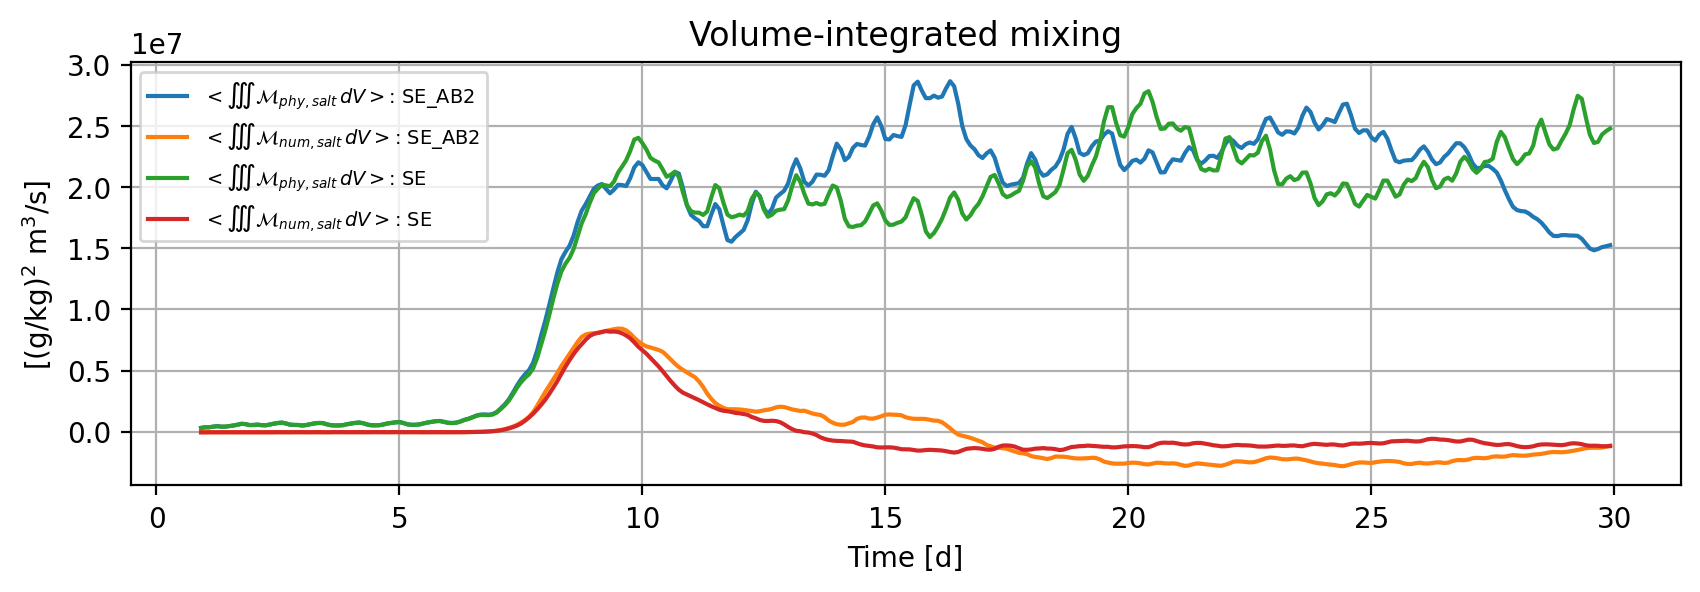

In [38]:
fig, ax = plt.subplots(1,figsize=(10,2.75),dpi=200)

time = (np.arange(0, len(dsd.xtime)) * (2/24))#[0:-1]

plt.plot(time,mphy_salt_dv.rolling(Time=12).mean(), label = r'$<\iiint \mathcal{M}_{phy,salt} \, dV>$: SE_AB2')
plt.plot(time,mnum_salt_dv.rolling(Time=12).mean(), label = r'$<\iiint \mathcal{M}_{num,salt} \, dV>$: SE_AB2')
# plt.plot(time,mphy_salt_dv2.rolling(Time=12).mean(), label = r'$\iiint \mathcal{M}_{phy,salt} \, dV$: SE_AB2_adv_0.25')
# plt.plot(time,mnum_salt_dv2.rolling(Time=12).mean(), label = r'$\iiint \mathcal{M}_{num,salt} \, dV$: SE_Ab2_adv_0.25')
plt.plot(time,mphy_salt_dv1.rolling(Time=12).mean(), label = r'$<\iiint \mathcal{M}_{phy,salt} \, dV>$: SE')
plt.plot(time,mnum_salt_dv1.rolling(Time=12).mean(), label = r'$<\iiint \mathcal{M}_{num,salt} \, dV>$: SE')
# plt.plot(time,mphy_temp_dv, label = r'$\iiint \mathcal{M}_{phy, temp} \, dV$')
# plt.plot(time,mnum_temp_dv, label = r'$\iiint \mathcal{M}_{num, temp} \, dV$')

plt.grid()
plt.xlabel('Time [d]')
plt.ylabel(r'[(g/kg)$^2$ m$^3$/s]')
plt.title('Volume-integrated mixing')
plt.legend(ncol = 1,fontsize=7)
# plt.xlim(0,20)

In [118]:
# # Choose one root directory, useful for multiple resolutions
path1 = '/pscratch/sd/d/dylan617/bichan/mpaso/1km/analysis_members/discreteVarianceDecay.0001-01-01.nc'
path2 = '/pscratch/sd/d/dylan617/bichan/mpaso/2km/analysis_members/discreteVarianceDecay_disable.0001-01-01.nc'
path5 = '/pscratch/sd/d/dylan617/bichan/mpaso/5km/analysis_members/discreteVarianceDecay.0001-01-01.nc'
path10 = '/pscratch/sd/d/dylan617/bichan/mpaso/10km/analysis_members/discreteVarianceDecay_disable_ab2_remap.0001-01-01.nc'

dsd1 = xr.open_dataset(path1)
dsd2 = xr.open_dataset(path2)
dsd5 = xr.open_dataset(path5)
dsd10 = xr.open_dataset(path10)

interp_mphy(dsd1)
interp_mphy(dsd2)
interp_mphy(dsd5)
interp_mphy(dsd10

In [119]:
path1 = '/pscratch/sd/d/dylan617/bichan/mpaso/1km/output.nc'
path2 = '/pscratch/sd/d/dylan617/bichan/mpaso/2km/output_disable.nc'
path5 = '/pscratch/sd/d/dylan617/bichan/mpaso/5km/output.nc'
path10 = '/pscratch/sd/d/dylan617/bichan/mpaso/10km/output_disable.nc'

dso1 = xr.open_dataset(path1).isel(Time=slice(1, None))
dso2 = xr.open_dataset(path2).isel(Time=slice(1, None))
dso5 = xr.open_dataset(path5).isel(Time=slice(1, None))
dso10 = xr.open_dataset(path10).isel(Time=slice(1, None))

path1 = '/pscratch/sd/d/dylan617/bichan/mpaso/1km/channel_1km_init.nc'
path2 = '/pscratch/sd/d/dylan617/bichan/mpaso/2km/channel_2km_init.nc'
path5 = '/pscratch/sd/d/dylan617/bichan/mpaso/5km/channel_5km_init.nc'
path10 = '/pscratch/sd/d/dylan617/bichan/mpaso/10km/channel_10km_init.nc'

dsg1 = xr.open_dataset(path1)
dsg2 = xr.open_dataset(path2)
dsg5 = xr.open_dataset(path5)
dsg10 = xr.open_dataset(path10)

center_vertices(dsg1, 1e3)
center_vertices(dsg2, 2e3)
center_vertices(dsg5, 5e3)
center_vertices(dsg10, 10e3)

In [120]:
def calc_mix(dsd,dso,dsg):

    xcell = dsg.xCell.values
    ycell = dsg.yCell.values

    # Remove 2 km aways from the boundaries to get rid of any noise. 
    # Not sure if this is enough, obviously doesn't work for 5- and 10 km case
    mask = np.logical_and.reduce([
        xcell > 2000,
        xcell < 98000,
        ycell > 2000,
        ycell < 298000
    ])

    # Get indices where condition is True
    idx = np.where(mask)[0]
    mnum_salt_dv = (
        dsd.chiSpurSaltBR08.isel(nCells=idx) *
        dso.layerThickness.isel(nCells=idx) *
        dsg.areaCell.isel(nCells=idx)
    ).sum(['nVertLevels', 'nCells']).load()
    mnum_salt_dv.name='mnum'
    
    mphy_salt_dv = (
        dsd.chiPhyVerSalt.isel(nCells=idx) *
        dso.layerThickness.isel(nCells=idx) *
        dsg.areaCell.isel(nCells=idx)
    ).sum(['nVertLevels', 'nCells']).load()
    mphy_salt_dv.name='mphy'

    dsm = xr.merge([mnum_salt_dv,mphy_salt_dv])
    return dsm

In [121]:
# This will take a while. Eventually you'll have to save to netcdf then load in. 
# This is for a one off
# dsm10 = calc_mix(dsd10,dso10,dsg10)
# dsm5 = calc_mix(dsd5,dso5,dsg5)
### Anything below 5 km will take a while, could put this in a script

# dsm2 = calc_mix(dsd2,dso2,dsg2)
dsm1 = calc_mix(dsd1,dso1,dsg1)

In [123]:
# fig, ax = plt.subplots(1,figsize=(10,2.75),dpi=200)

# time = (np.arange(0, len(dsd10.xtime)) * (2/24))#[0:-1]

# plt.plot(time,dsm10.mphy.rolling(Time=12).mean(), c = 'k', label = r'10km: $<\iiint \mathcal{M}_{phy}>$')
# plt.plot(time,dsm10.mnum.rolling(Time=12).mean(), c = 'k', ls = '--',label = r'10km: $<\iiint \mathcal{M}_{num}>$')

# plt.plot(time,dsm5.mphy.rolling(Time=8,center=True).mean(), c = 'r', label = r'5km: $<\iiint \mathcal{M}_{phy}>$')
# plt.plot(time,dsm5.mnum.rolling(Time=8,center=True).mean(), c = 'r', ls = '--',label = r'5km: $<\iiint \mathcal{M}_{num}>$')

# plt.plot(time,dsm2.mphy.rolling(Time=8,center=True).mean(), c = 'b', label = r'2km: $<\iiint \mathcal{M}_{phy}>$')
# plt.plot(time,dsm2.mnum.rolling(Time=8,center=True).mean(), c = 'b', ls = '--',label = r'2km: $<\iiint \mathcal{M}_{num}>$')

# plt.plot(time,dsm1.mphy.rolling(Time=8,center=True).mean(), c = 'm', label = r'1km: $<\iiint \mathcal{M}_{phy}>$')
# plt.plot(time,dsm1.mnum.rolling(Time=8,center=True).mean(), c = 'm', ls = '--',label = r'1km: $<\iiint \mathcal{M}_{num}>$')
# plt.grid()
# plt.xlabel('Time [d]')
# plt.ylabel(r'[(g/kg)$^2$ m$^3$/s]')
# plt.title('Volume-integrated salinity mixing')
# plt.legend(ncol = 1,fontsize=7)
# # plt.xlim(0,20)

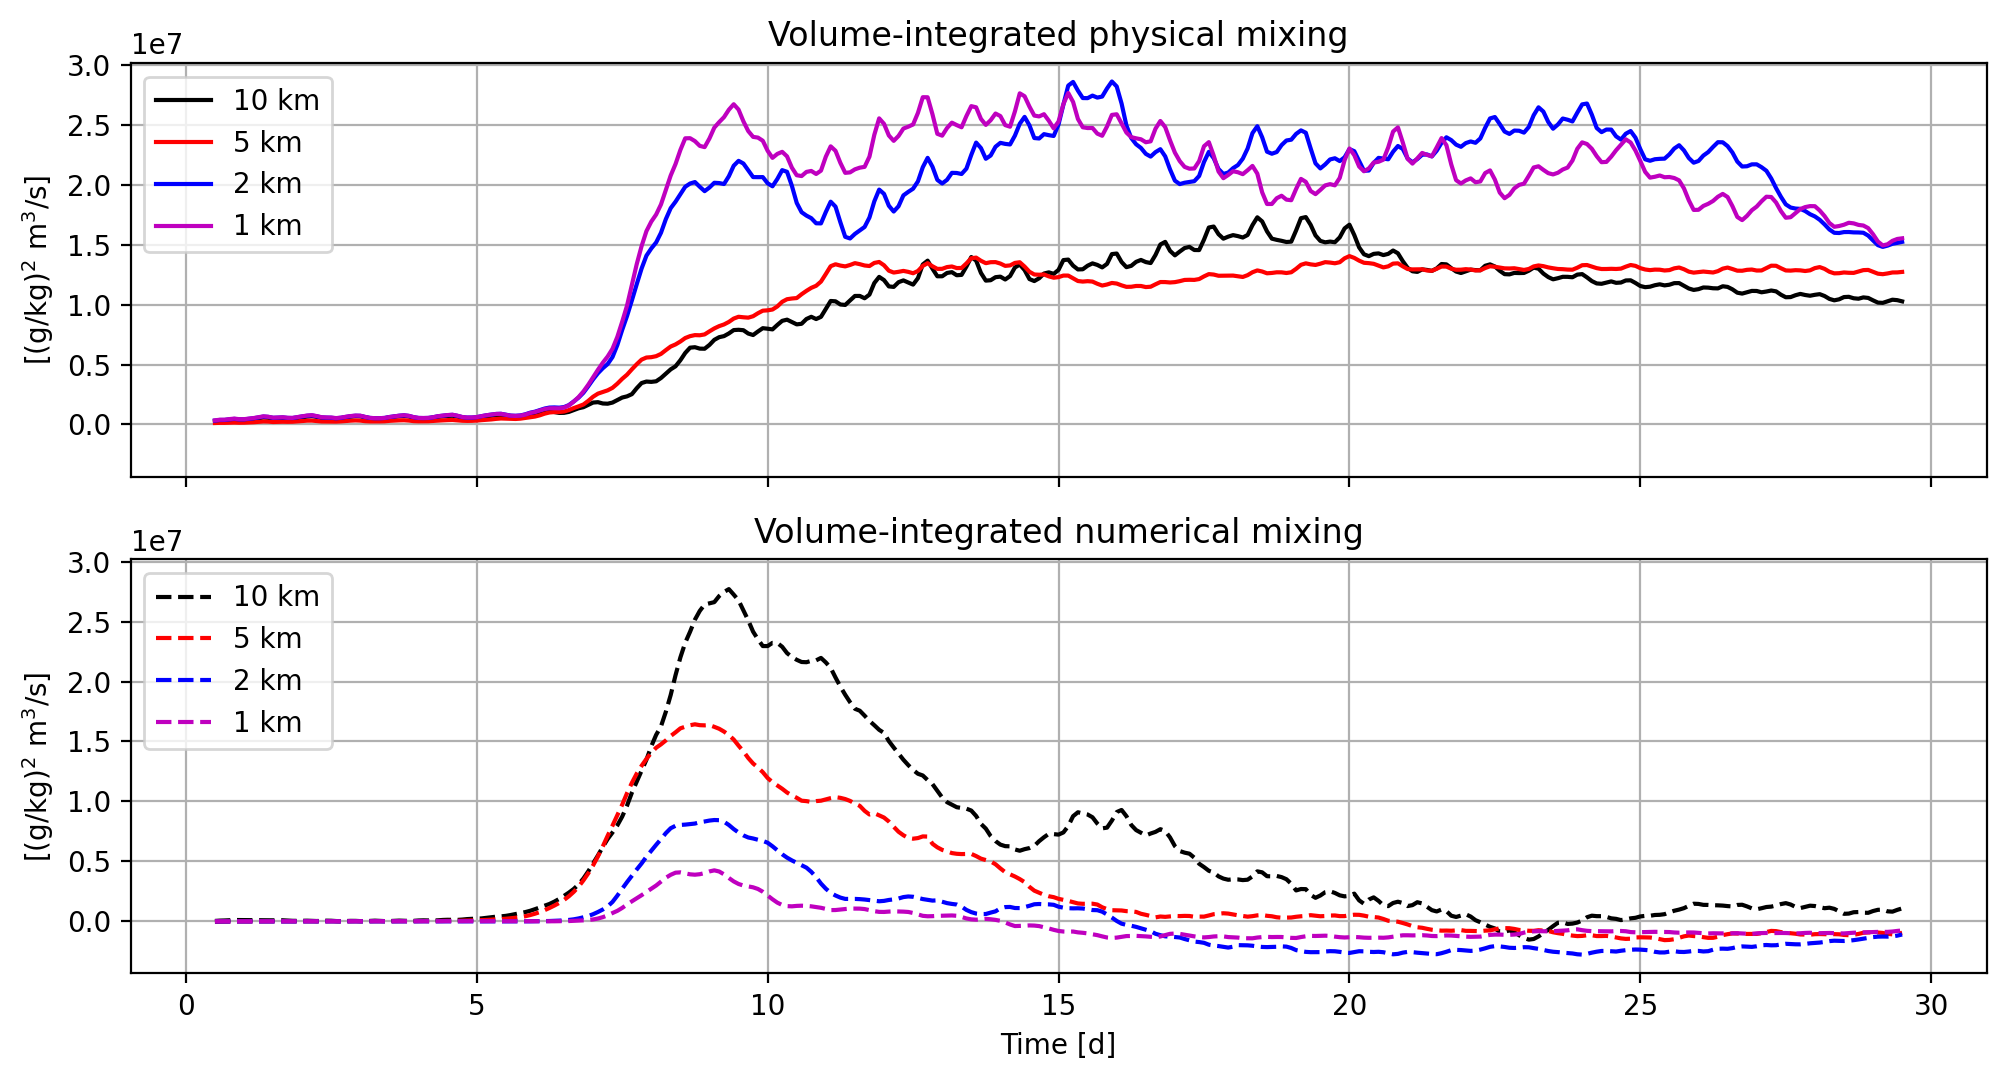

In [122]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5.5), dpi=200, sharex=True,sharey=True)

time = (np.arange(0, len(dsd10.xtime)) * (2/24))  # Assuming 2-hour intervals

# --- Physical Mixing Subplot ---
ax = axes[0]
ax.plot(time, dsm10.mphy.rolling(Time=12,center=True).mean(), c='k', label=r'10 km')
ax.plot(time, dsm5.mphy.rolling(Time=12, center=True).mean(), c='r', label=r'5 km')
ax.plot(time, dsm2.mphy.rolling(Time=12, center=True).mean(), c='b', label=r'2 km')
ax.plot(time, dsm1.mphy.rolling(Time=12, center=True).mean(), c='m', label=r'1 km')
ax.set_ylabel(r'[(g/kg)$^2$ m$^3$/s]')
ax.set_title('Volume-integrated physical mixing')
ax.grid()
ax.legend(loc='upper left')

# --- Numerical Mixing Subplot ---
ax = axes[1]
ax.plot(time, dsm10.mnum.rolling(Time=12,center=True).mean(), c='k', ls='--', label=r'10 km')
ax.plot(time, dsm5.mnum.rolling(Time=12, center=True).mean(), c='r', ls='--', label=r'5 km')
ax.plot(time, dsm2.mnum.rolling(Time=12, center=True).mean(), c='b', ls='--', label=r'2 km')
ax.plot(time, dsm1.mnum.rolling(Time=12, center=True).mean(), c='m', ls='--', label=r'1 km')
ax.set_xlabel('Time [d]')
ax.set_ylabel(r'[(g/kg)$^2$ m$^3$/s]')
ax.set_title('Volume-integrated numerical mixing')
ax.grid()
ax.legend(loc='upper left')

plt.tight_layout()
# plt.xlim(0, 20)  # Uncomment if you want to limit the time range


In [112]:
dsd.xtime[:12*14].values[-1]

np.bytes_(b'0001-01-15_00:00:00')

### Scatter plot of resolutions 

Text(0.5, 1.0, 'Ratio of numerical to physical mixing')

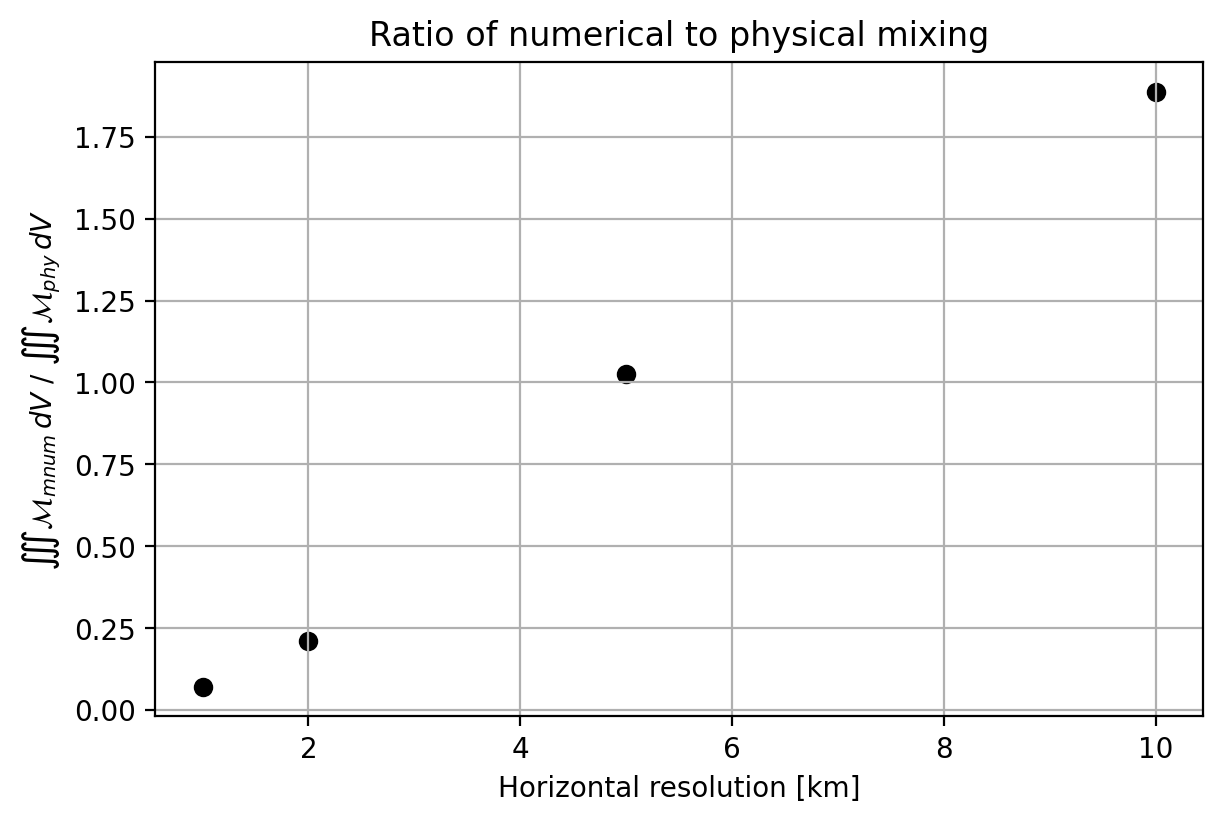

In [129]:
fig,ax=plt.subplots(1,figsize=(6,4),dpi=200,constrained_layout=True)

xx = [1,2,5,10]

# First 15 days before it becomes negative for most resolutions 
plt.scatter(xx[3],dsm10.mnum[:12*14].sum()/dsm10.mphy[:12*14].sum(),c='k')
plt.scatter(xx[2],dsm5.mnum[:12*14].sum()/dsm5.mphy[:12*14].sum(),c='k')
plt.scatter(xx[1],dsm2.mnum[:12*14].sum()/dsm2.mphy[:12*14].sum(),c='k')
plt.scatter(xx[0],dsm1.mnum[:12*14].sum()/dsm1.mphy[:12*14].sum(),c='k')
ax.set_xlabel('Horizontal resolution [km]')
plt.grid()
ax.set_ylabel('$\iiint \mathcal{M}_{mnum} \, dV $ / $\iiint \mathcal{M}_{phy} \, dV $')
plt.title('Ratio of numerical to physical mixing')